# <center>FILM PRODUCTION RECOMMENDATION</center>

This notebook uses the IMDb dataset to make a recommendation to a fictional local independent film production company. 

The company want their next film to be either a horror or romance and they want to make this choice based on films' IMDb rating. They also need to know which director and actor(s) to approach to make their film. 

In this notebook, I carry out data cleaning and wrangling, initial exploratory data analysis and hypothesis testing in order to make the recommendations. 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
print (pd.__version__)
print (np.__version__)
print (sns.__version__)

2.2.2
1.26.4
0.13.2


In [6]:
from warnings import filterwarnings
filterwarnings('ignore')

## Section 1: Data Cleaning and Wrangling

In [155]:
df = pd.read_csv('movie_metadata.csv')
df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


I observe that there are a lot of columns, so I'm going to use .info() to find out how many and what they are

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

The first thing to check is whether any of the dataframe entries (i.e. movie titles appear more than once). The data collector has told us to remove all duplicates, retaining the first entry

In [159]:
print(df.duplicated("movie_title").any())
sum(df.duplicated("movie_title"))

True


126

There are 126 duplicated titles, we should remove all but the first entry for all duplicates 

In [161]:
df.drop_duplicates("movie_title",keep="first",inplace=True,ignore_index=True)
df.shape

(4917, 28)

Dropped 126 duplicates, keeping only the first entry. This reduces rows from 5043 to 4917.

Next I need to remove rows with NaNs in relevant columns (imdb score, director name, actor names, year)

In [163]:
# Columns to check for missing values
required_columns = ['director_name', 'actor_1_name', 'title_year']

# Drop rows with NaNs in any of these columns
df = df.dropna(subset=required_columns).reset_index(drop=True)

print(f"Cleaned dataset: {len(df)} rows remaining.")

Cleaned dataset: 4804 rows remaining.


We know that the whole data set is for 100 years, I want to find out the date range of the whole data set, because the older the data, the less relevent it is for projected box office success

In [165]:
df['title_year'].agg(['min', 'max'])

min    1916.0
max    2016.0
Name: title_year, dtype: float64

The dataset spans 100 years, but only the most recent years of box office data will be relevent to projected box office success. After checking with the data collector/ manager I have decided to only use the most recent 10 year's worth of data, as this strikes a reasonable balance between relevance and sufficient size of dataset. I will remove all the rows for films released before 2006

In [167]:
years_removed=df['title_year']<2006
to_be_removed = years_removed
print (f'Number to remove = {sum(to_be_removed)}, which is {100*sum(to_be_removed)/len(to_be_removed):.2f}%of the data')


Number to remove = 2455, which is 51.10%of the data


While this is quite a large percentage, it is necessary to make the recommendations relevant

In [170]:
df = df[~to_be_removed]
df.reset_index(drop=True, inplace=True)
print (df['title_year'].agg(['min', 'max'])) #double-check df2 is for desired date range 

min    2006.0
max    2016.0
Name: title_year, dtype: float64


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      2335 non-null   object 
 1   director_name              2349 non-null   object 
 2   num_critic_for_reviews     2316 non-null   float64
 3   duration                   2339 non-null   float64
 4   director_facebook_likes    2349 non-null   float64
 5   actor_3_facebook_likes     2343 non-null   float64
 6   actor_2_name               2346 non-null   object 
 7   actor_1_facebook_likes     2349 non-null   float64
 8   gross                      1887 non-null   float64
 9   genres                     2349 non-null   object 
 10  actor_1_name               2349 non-null   object 
 11  movie_title                2349 non-null   object 
 12  num_voted_users            2349 non-null   int64  
 13  cast_total_facebook_likes  2349 non-null   int64

The task is to recommend either the comedy or horror genre based on IMDb score... Explore the IMDb score stats

In [180]:
print (df.num_voted_users.agg(['min', 'max', 'median', 'mean']).round())

min             5.0
max       1676169.0
median      35446.0
mean        83977.0
Name: num_voted_users, dtype: float64


I need to consider the number of users voting for the IMDb score. Any movies which had a low number of users rating them (num_voted_useres) should be removed as these ratings will be less reliable. On the IMDb top 250 chart (https://www.imdb.com/chart/top/) they only include films that received ratings from at least 25000 users. However this may limit our sample size too greatly. 


In [182]:
low_user_reviews1=df.num_voted_users<100
low_user_reviews2=df.num_voted_users<25000
print (f'There are {sum(low_user_reviews1)} films that have fewer than 100 users voting for the IMDb score and {sum(low_user_reviews2)} that have fewer than 25000')
print (f'Number to be removed if we filter out reviews with less than 100 users = {sum(low_user_reviews1)}, which is {100*sum(low_user_reviews1)/len(low_user_reviews1):.2f}%of the data')
print (f'Number to be removed if we filter out reviews with less than 25000 users = {sum(low_user_reviews2)}, which is {100*sum(low_user_reviews2)/len(low_user_reviews2):.2f}%of the data')

There are 74 films that have fewer than 100 users voting for the IMDb score and 1008 that have fewer than 25000
Number to be removed if we filter out reviews with less than 100 users = 74, which is 3.15%of the data
Number to be removed if we filter out reviews with less than 25000 users = 1008, which is 42.91%of the data



Removing reviews with less than 25000 users seems excessive and will remove over 40% of the data. Instead, I will remove reviews with less than 100 users as this retains a balance between filtering out films with ratings that are statistically irrelevant (because only a small number of users voted) and reducing the size of the sample too much

In [184]:
to_be_removed = low_user_reviews1 #dropping films with less than 100 user reviews
df = df[~to_be_removed]
df.reset_index(drop=True, inplace=True)
print (f'Number of films remaining is {df.shape[0]}')

Number of films remaining is 2275


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      2261 non-null   object 
 1   director_name              2275 non-null   object 
 2   num_critic_for_reviews     2262 non-null   float64
 3   duration                   2267 non-null   float64
 4   director_facebook_likes    2275 non-null   float64
 5   actor_3_facebook_likes     2270 non-null   float64
 6   actor_2_name               2273 non-null   object 
 7   actor_1_facebook_likes     2275 non-null   float64
 8   gross                      1877 non-null   float64
 9   genres                     2275 non-null   object 
 10  actor_1_name               2275 non-null   object 
 11  movie_title                2275 non-null   object 
 12  num_voted_users            2275 non-null   int64  
 13  cast_total_facebook_likes  2275 non-null   int64

There are no NaNs in relevant columns, so I can proceed for now

I'm now going to find the top 10 movies according to IMDb score. I only want to display the relevant columns here, so I'll just choose to show the film title, its year of release, the director's name and the leading 3 actor's names, the gross, budget and the number of users that voted for the film, genre, and imdb score

In [190]:
# top films by IMDb score
df.sort_values(by=["imdb_score"],ascending=False)[['movie_title','title_year', 'imdb_score', 
'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'genres']].head(10)

,movie_title,title_year,imdb_score,director_name,actor_1_name,actor_2_name,actor_3_name,genres
2008,Kickboxer: Vengeance,2016.0,9.1,John Stockwell,Matthew Ziff,T.J. Storm,Sam Medina,Action
61,The Dark Knight,2008.0,9.0,Christopher Nolan,Christian Bale,Heath Ledger,Morgan Freeman,Action|Crime|Drama|Thriller
88,Inception,2010.0,8.8,Christopher Nolan,Leonardo DiCaprio,Tom Hardy,Joseph Gordon-Levitt,Action|Adventure|Sci-Fi|Thriller
2036,Queen of the Mountains,2014.0,8.7,Sadyk Sher-Niyaz,Elina Abai Kyzy,Aziz Muradillayev,Mirlan Abdulayev,Action|Biography|Drama|History
87,Interstellar,2014.0,8.6,Christopher Nolan,Matthew McConaughey,Anne Hathaway,Mackenzie Foy,Adventure|Drama|Sci-Fi
1798,Samsara,2011.0,8.5,Ron Fricke,Collin Alfredo St. Dic,Balinese Tari Legong Dancers,Puti Sri Candra Dewi,Documentary|Music
1842,Whiplash,2014.0,8.5,Damien Chazelle,J.K. Simmons,Melissa Benoist,Chris Mulkey,Drama|Music
3,The Dark Knight Rises,2012.0,8.5,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,Action|Thriller
606,The Prestige,2006.0,8.5,Christopher Nolan,Christian Bale,Hugh Jackman,Scarlett Johansson,Drama|Mystery|Sci-Fi|Thriller
246,The Departed,2006.0,8.5,Martin Scorsese,Leonardo DiCaprio,Matt Damon,Ray Winstone,Crime|Drama|Thriller


The client wants recommendations of specific directors and actors to approach for their next film, which they've specified they want to be either a Romance or a Horror. First, I need to find out how many genres there are in the dataset and what they are.

In [193]:
df.genres.nunique() #returns the number of unique genres

569

In [195]:
df.genres.unique() #lists the unique genres

array(['Action|Adventure|Fantasy|Sci-Fi', 'Action|Adventure|Fantasy',
       'Action|Adventure|Thriller', 'Action|Thriller',
       'Action|Adventure|Sci-Fi', 'Action|Adventure|Romance',
       'Adventure|Animation|Comedy|Family|Fantasy|Musical|Romance',
       'Adventure|Family|Fantasy|Mystery', 'Action|Adventure',
       'Action|Adventure|Western', 'Action|Adventure|Family|Fantasy',
       'Action|Adventure|Comedy|Family|Fantasy|Sci-Fi',
       'Adventure|Fantasy', 'Action|Adventure|Drama|History',
       'Adventure|Family|Fantasy', 'Action|Adventure|Sci-Fi|Thriller',
       'Action|Adventure|Fantasy|Sci-Fi|Thriller',
       'Adventure|Animation|Comedy|Family|Fantasy',
       'Adventure|Animation|Comedy|Family|Sport', 'Action|Crime|Thriller',
       'Action|Adventure|Horror|Sci-Fi|Thriller', 'Drama|Romance',
       'Action|Adventure|Fantasy|Romance',
       'Adventure|Animation|Family|Sci-Fi',
       'Action|Comedy|Crime|Thriller', 'Animation|Drama|Family|Fantasy',
       'Action|Adv

I need to split these elaborately over-hybridised genres into their constituent 'single' genres. I will do this through split explode on the genre strings by the pipe delimiter to create a new dataframe (split_genres_df)

In [197]:
df['genres'] = df['genres'].str.split('|') #splits by pipe
split_genres_df = df.explode('genres') #creates a new row for each genre for each film

In [199]:
split_genres_df.genres.unique()

array(['Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thriller', 'Romance',
       'Animation', 'Comedy', 'Family', 'Musical', 'Mystery', 'Western',
       'Drama', 'History', 'Sport', 'Crime', 'Horror', 'War', 'Biography',
       'Music', 'Documentary', 'News', 'Short'], dtype=object)

In [201]:
print ('There are now', split_genres_df.genres.nunique(), 'unique genres')

There are now 23 unique genres


In [203]:
split_genres_df.head()[["movie_title", "genres"]]

,movie_title,genres
0,Avatar,Action
0,Avatar,Adventure
0,Avatar,Fantasy
0,Avatar,Sci-Fi
1,Pirates of the Caribbean: At World's End,Action


Due to using split explode to separate out the genres, films are now listed multiple times in the dataframe. Handle this later when comparing specific genres

## Section 2: Summary Statistics

Next, to find out which are the top five individual genres with the most numbers of films in the dataframe and to produce some summary statistics on them

In [205]:
split_genres_df.groupby(['genres']).size().sort_values(ascending=False) #use groupby to find the number of films in each genre

genres
Drama          1141
Comedy          827
Thriller        645
Action          523
Romance         455
Adventure       411
Crime           354
Fantasy         281
Horror          278
Sci-Fi          273
Family          266
Mystery         220
Biography       154
Animation       147
History          95
Music            95
War              85
Sport            75
Documentary      62
Musical          46
Western          33
News              3
Short             3
dtype: int64

I want to create an additional dataframe that filters out the low-count genres, i.e. genres that have less than 50 films. This will be useful later on in the statistical analysis

In [207]:
#exclude any genres with fewer than 30 films in them
filtered_split_genres_df = split_genres_df.groupby(['genres']).filter(lambda x: len(x) >= 30) 

In [209]:
filtered_split_genres_df.movie_title.nunique() #find the number of unique titles 

2275

In [211]:
filtered_split_genres_df.groupby(['genres']).size().sort_values(ascending=False) 
#check that we've removed genres with less than 30 films in them

genres
Drama          1141
Comedy          827
Thriller        645
Action          523
Romance         455
Adventure       411
Crime           354
Fantasy         281
Horror          278
Sci-Fi          273
Family          266
Mystery         220
Biography       154
Animation       147
History          95
Music            95
War              85
Sport            75
Documentary      62
Musical          46
Western          33
dtype: int64

Below, I'm exploring the summary statistics of IMDb score for all the genres, sorted in descending order of total number of films per genre. 

#### Summary Statitics for IMDb Score

In [214]:
#create dataframes for IMDb score
df1=filtered_split_genres_df.groupby(['genres']).imdb_score.describe().sort_values('count',ascending=False).reset_index()
df1

,genres,count,mean,std,min,25%,50%,75%,max
0,Drama,1141.0,6.602805,0.961154,2.0,6.100,6.70,7.30,9.0
1,Comedy,827.0,6.097098,1.069573,1.7,5.500,6.20,6.80,8.4
2,Thriller,645.0,6.168992,1.097315,2.2,5.500,6.30,6.90,9.0
3,Action,523.0,6.204207,1.117735,1.7,5.600,6.30,6.90,9.1
4,Romance,455.0,6.363736,0.923997,2.7,5.800,6.40,7.10,8.4
5,Adventure,411.0,6.459854,1.065040,2.3,5.850,6.60,7.20,8.8
6,Crime,354.0,6.461864,0.948109,3.1,6.000,6.50,7.10,9.0
7,Fantasy,281.0,6.206050,1.091558,1.7,5.500,6.30,7.00,8.4
8,Horror,278.0,5.580935,1.075001,2.2,5.000,5.70,6.30,8.2
9,Sci-Fi,273.0,6.340659,1.105166,2.7,5.800,6.40,7.00,8.8


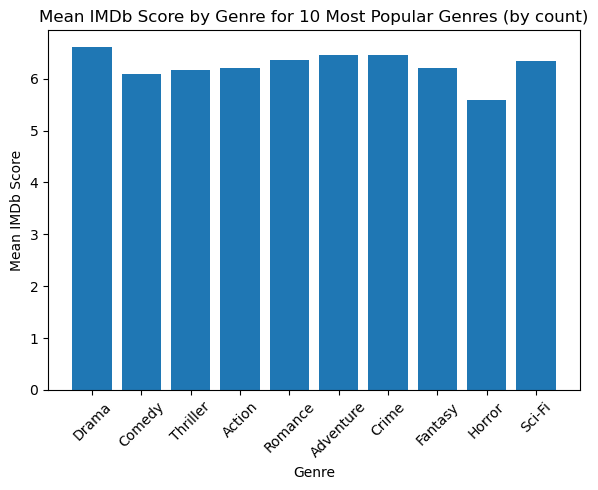

In [343]:
# Sort genres by number of movies and take top 10 for better visibility
top_genres = df1.sort_values('count', ascending=False).head(10)

# Plot mean IMDb scores
plt.figure(figsize=(6, 5))
plt.bar(top_genres['genres'], top_genres['mean'])

plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Mean IMDb Score')
plt.title('Mean IMDb Score by Genre for 10 Most Popular Genres (by count)')
plt.tight_layout()
plt.show()

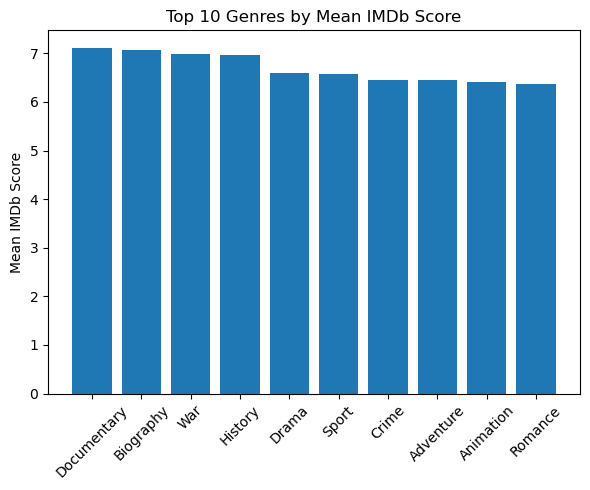

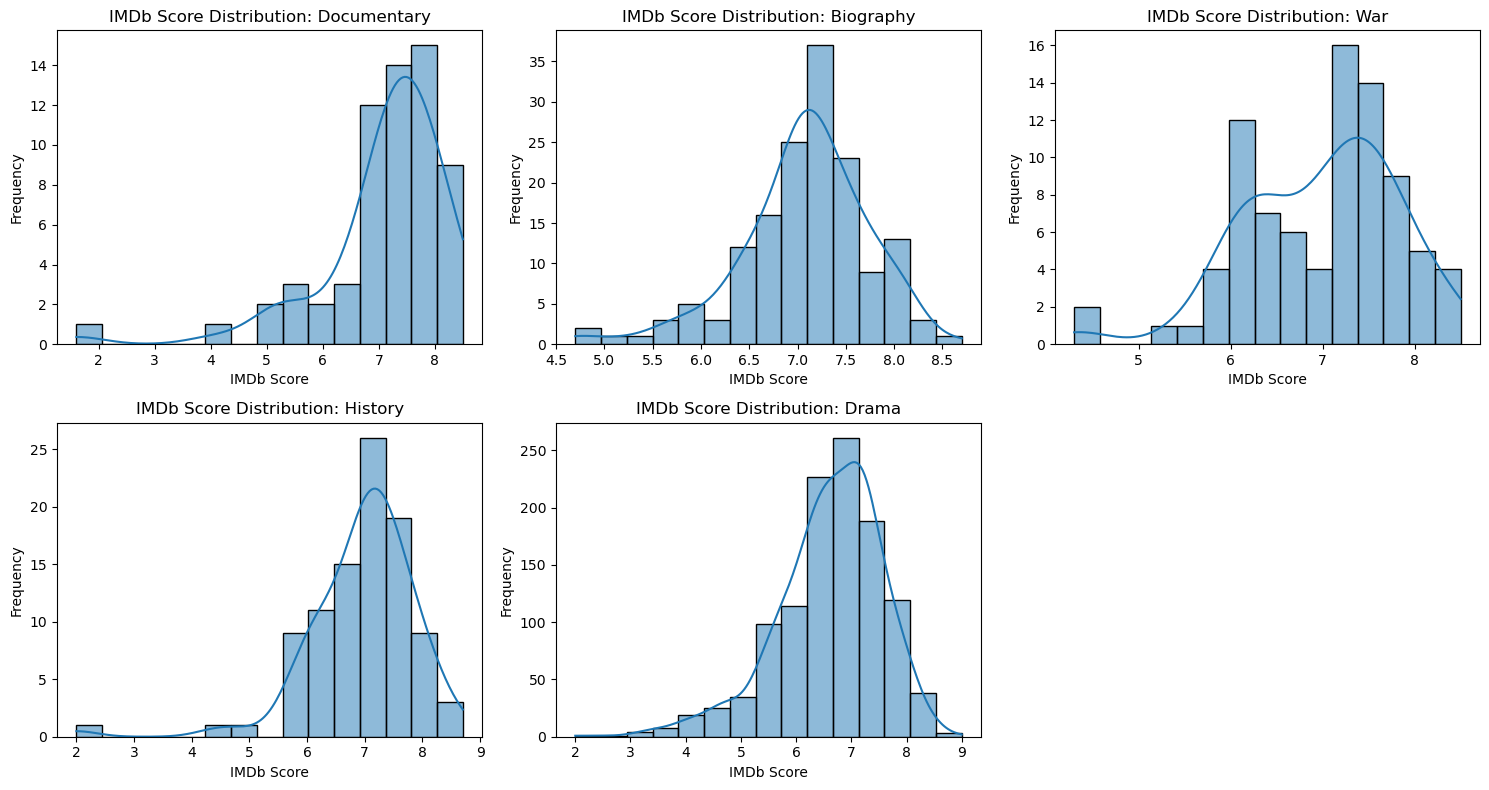

IMDb Score Summary Stats for Top 5 Genres:
              count      mean       std  min    25%  50%  75%  max
genres                                                            
Biography     154.0  7.071429  0.663198  4.7  6.725  7.1  7.5  8.7
Documentary    62.0  7.117742  1.151268  1.6  6.925  7.4  7.7  8.5
Drama        1141.0  6.602805  0.961154  2.0  6.100  6.7  7.3  9.0
History        95.0  6.965263  0.923196  2.0  6.550  7.1  7.5  8.7
War            85.0  6.977647  0.837993  4.3  6.300  7.1  7.6  8.5


In [347]:
# Full summary stats by genre
df1 = filtered_split_genres_df.groupby('genres')['imdb_score'].describe().reset_index()

# Top 10 genres by mean IMDb score — for bar plot
top10_genres = df1.sort_values('mean', ascending=False).head(10)

# Bar plot of top 10 genres by mean IMDb score
plt.figure(figsize=(6, 5))
plt.bar(top10_genres['genres'], top10_genres['mean'])
plt.xticks(rotation=45)
plt.ylabel('Mean IMDb Score')
plt.title('Top 10 Genres by Mean IMDb Score')
plt.tight_layout()
plt.show()

# Top 5 genres by mean IMDb score — for distribution + stats
top5_genres = top10_genres.head(5)['genres'].tolist()

# Filter main dataset to those genres
top5_df = filtered_split_genres_df[filtered_split_genres_df['genres'].isin(top5_genres)]

# Plot IMDb score distribution for each of top 5 genres
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, genre in enumerate(top5_genres):
    ax = axes[i]
    sns.histplot(
        data=top5_df[top5_df['genres'] == genre],
        x='imdb_score',
        bins=15,
        kde=True,
        ax=ax
    )
    ax.set_title(f"IMDb Score Distribution: {genre}")
    ax.set_xlabel('IMDb Score')
    ax.set_ylabel('Frequency')

# Hide unused subplot
for j in range(len(top5_genres), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print full summary stats for top 5 genres
print("IMDb Score Summary Stats for Top 5 Genres:")
print(df1[df1['genres'].isin(top5_genres)].set_index('genres'))

## Section 3: Hypothesis Testing

In this section I'm going to run some hypothesis tests to see which genre (out of Romance adn Horror) we should advise the client to invest in. <br><br>
First, I need to check for overlaps to ensure independence for the hypothesis testing. 

In [309]:
Horror = split_genres_df.groupby(['genres']).get_group('Horror').reset_index() #Using get_group to create a new dataframe for the Horror genre 
Romance = split_genres_df.groupby(['genres']).get_group('Romance').reset_index()

In [311]:
from collections import Counter

def check_movie_title_overlap(Horror, Romance):
    # Extract and normalize titles
    horror_titles = Horror['movie_title'].dropna().astype(str).str.strip()
    romance_titles = Romance['movie_title'].dropna().astype(str).str.strip()

    # Combine and count
    all_titles = pd.concat([horror_titles, romance_titles])
    title_counts = Counter(all_titles)

    # Find duplicates
    duplicate_titles = {title for title, count in title_counts.items() if count > 1}

    # Count overlaps
    horror_dupes = horror_titles.isin(duplicate_titles).sum()
    romance_dupes = romance_titles.isin(duplicate_titles).sum()
    horror_pct = horror_dupes / len(horror_titles) * 100
    romance_pct = romance_dupes / len(romance_titles) * 100

    print("Duplicate Movie Title Summary:")
    print(f"Horror:  {horror_dupes} duplicates ({horror_pct:.2f}%)")
    print(f"Romance: {romance_dupes} duplicates ({romance_pct:.2f}%)")

    if duplicate_titles:
        print("\Overlapping Movie Titles:")
        for title in sorted(duplicate_titles):
            print(f"- {title}")
    else:
        print("No overlapping movie titles found — datasets are independent.")

    return duplicate_titles  # Return for further use if needed

# Call the function
duplicates = check_movie_title_overlap(Horror, Romance)


Duplicate Movie Title Summary:
Horror:  9 duplicates (3.24%)
Romance: 9 duplicates (1.98%)
\Overlapping Movie Titles:
- Baghead
- Blood and Chocolate
- Forget Me Not
- It's a Wonderful Afterlife
- Pride and Prejudice and Zombies
- The Eclipse
- The Mortal Instruments: City of Bones
- Vamps
- Warm Bodies


A small number of overlaps, which I will simply delete...

In [253]:
# Drop overlaps from both datasets using the returned set
Horror = Horror[~Horror['movie_title'].astype(str).str.strip().isin(duplicates)].copy()
Romance = Romance[~Romance['movie_title'].astype(str).str.strip().isin(duplicates)].copy()

print(f"✅ Removed {len(duplicates)} overlapping titles.")
print(f"Remaining: Horror = {len(Horror)}, Romance = {len(Romance)}")

✅ Removed 9 overlapping titles.
Remaining: Horror = 269, Romance = 446


In [257]:
Horror.head(5)[["director_name","movie_title","actor_1_name", 'actor_2_name', 'actor_3_name',"title_year", "imdb_score", "num_voted_users"]]

,director_name,movie_title,actor_1_name,actor_2_name,actor_3_name,title_year,imdb_score,num_voted_users
0,Marc Forster,World War Z,Peter Capaldi,Brad Pitt,Mireille Enos,2013.0,7.0,465019
1,Rob Cohen,The Mummy: Tomb of the Dragon Emperor,Jet Li,Brendan Fraser,Russell Wong,2008.0,5.2,117927
2,Hideaki Anno,Godzilla Resurgence,Mark Chinnery,Shin'ya Tsukamoto,Atsuko Maeda,2016.0,8.2,374
3,Francis Lawrence,I Am Legend,Will Smith,Alice Braga,Willow Smith,2007.0,7.2,530870
4,Tim Burton,Dark Shadows,Johnny Depp,Chloë Grace Moretz,Christopher Lee,2012.0,6.2,199039


In [259]:
Romance.head(5)[["director_name","movie_title","actor_1_name", 'actor_2_name', 'actor_3_name',"title_year", "imdb_score", "num_voted_users"]]

,director_name,movie_title,actor_1_name,actor_2_name,actor_3_name,title_year,imdb_score,num_voted_users
0,Sam Raimi,Spider-Man 3,J.K. Simmons,James Franco,Kirsten Dunst,2007.0,6.2,383056
1,Nathan Greno,Tangled,Brad Garrett,Donna Murphy,M.C. Gainey,2010.0,7.8,294810
2,Baz Luhrmann,The Great Gatsby,Leonardo DiCaprio,Elizabeth Debicki,Steve Bisley,2013.0,7.3,362912
3,Mike Newell,Prince of Persia: The Sands of Time,Jake Gyllenhaal,Richard Coyle,Reece Ritchie,2010.0,6.6,222403
4,David Yates,The Legend of Tarzan,Christoph Waltz,Alexander Skarsgård,Casper Crump,2016.0,6.6,42372


In [261]:
Horror.describe().round(1)[['imdb_score']]

,imdb_score
count,269.0
mean,5.6
std,1.1
min,2.2
25%,4.9
50%,5.7
75%,6.3
max,8.2


In [263]:
Romance.describe().round(1)[['imdb_score']]

,imdb_score
count,446.0
mean,6.4
std,0.9
min,2.7
25%,5.8
50%,6.5
75%,7.1
max,8.4


I'm going to visualise the above summary statistics for IMDb Score and Profit for the two genres in question using separate histograms and a compiled violin plot

Text(0.5, 1.0, 'Horror, Romance and Comedy IMDb Scores')

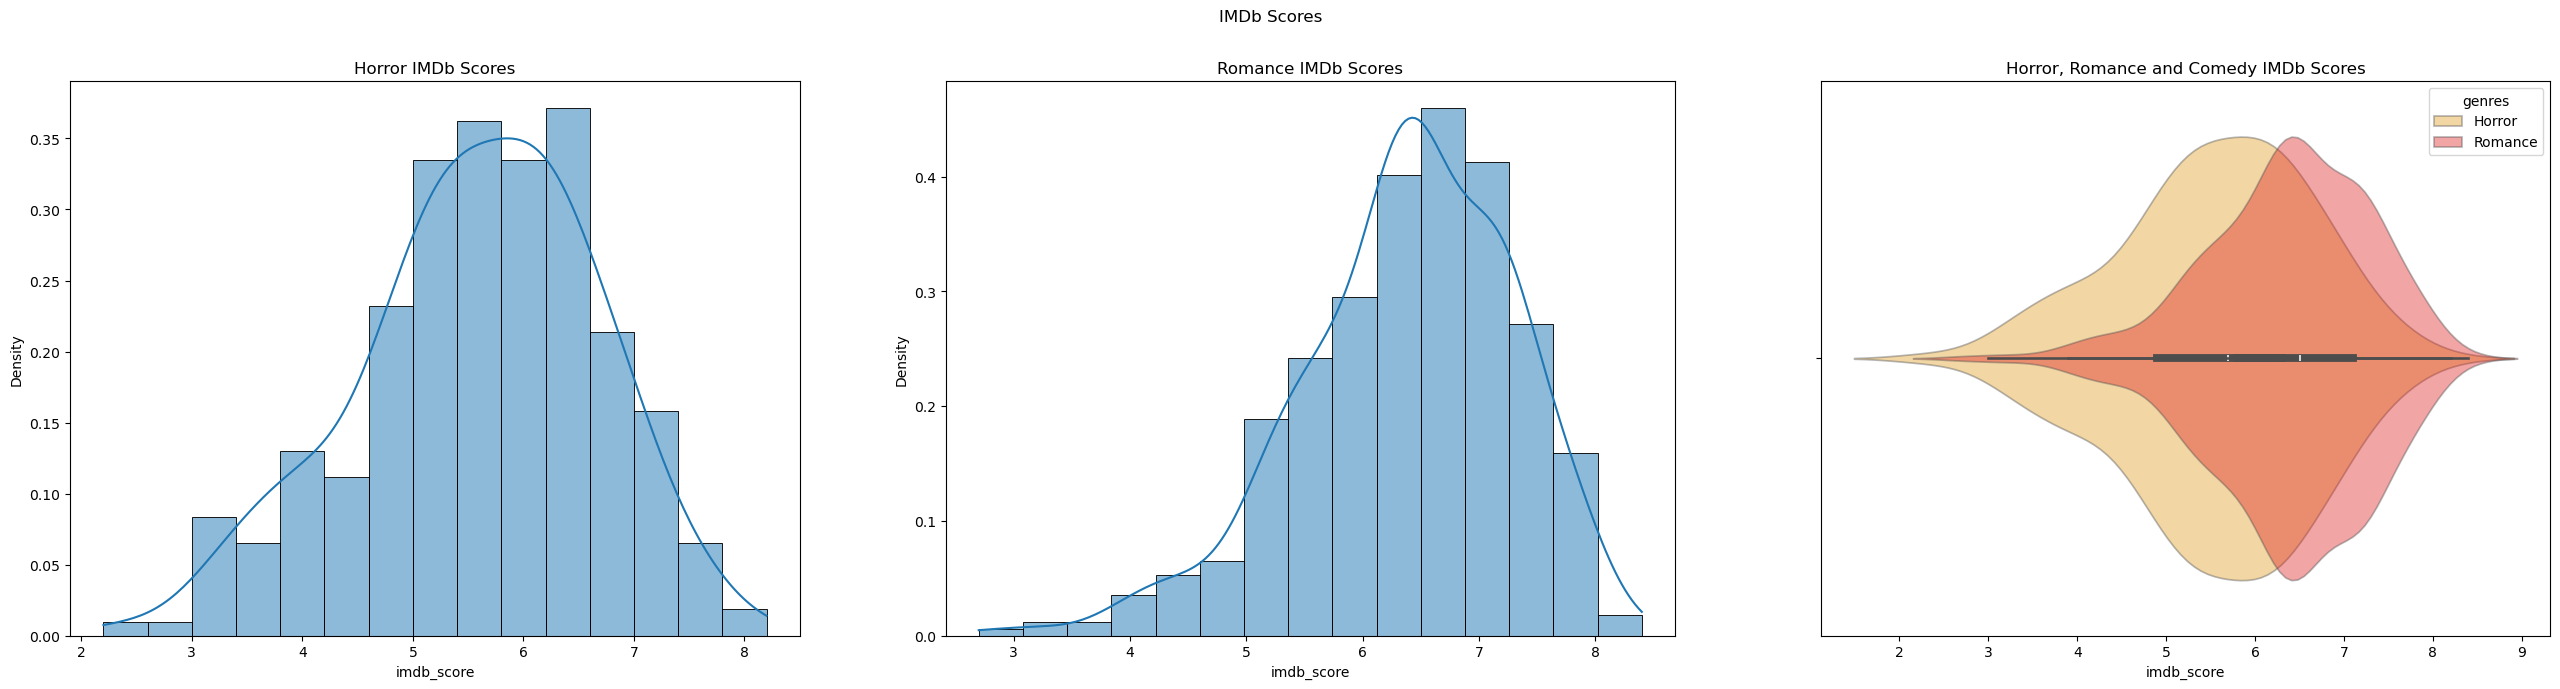

In [267]:
col= 'imdb_score'
fig, axes = plt.subplots(nrows=1, ncols=3)
palette1 = ['orange']
palette2= ['red']


sns.histplot(data=Horror, ax=axes[0], x=col, kde=True, bins = 15, stat='density')
sns.histplot(data=Romance, ax=axes[ 1],x=col, kde=True, bins = 15, stat='density')
sns.violinplot(data=Horror, ax=axes[2], x=col, hue='genres', palette=palette1, alpha=.4)
sns.violinplot(data=Romance, ax=axes[2],x=col, hue='genres', palette=palette2, alpha=.4)


fig.set_figwidth(fig.get_figwidth() * 5)
fig.set_figheight(fig.get_figheight() * 1.5)
fig.suptitle("IMDb Scores")

axes[0].set_title('Horror IMDb Scores')
axes[1].set_title('Romance IMDb Scores')
axes[2].set_title('Horror, Romance and Comedy IMDb Scores')


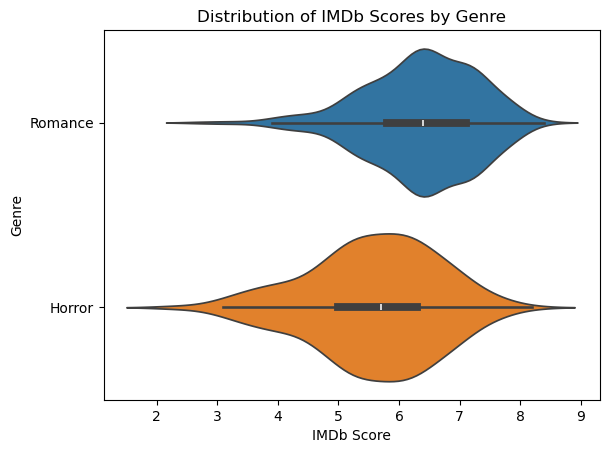

In [272]:
genres_to_keep = ['Horror', 'Romance']
two_genres = split_genres_df.groupby(['genres']).filter(lambda x: x.name in genres_to_keep)

sns.violinplot(data=two_genres, x="imdb_score", y="genres", hue='genres')
plt.title("Distribution of IMDb Scores by Genre")
plt.xlabel("IMDb Score")
plt.ylabel("Genre")

plt.show()

I also want to measure the kurtosis on both genres, to see how peaked they are as this will tell me how extreme the outliers are and how influential they are on the distribution

In [275]:
print (f'The kurtosis of the imdb score of the Horror genre is {Horror.imdb_score.kurtosis()}')
print (f'The kurtosis of the imdb score of the Romance genre is {Romance.imdb_score.kurtosis()}')

The kurtosis of the imdb score of the Horror genre is -0.10313189024209324
The kurtosis of the imdb score of the Romance genre is 0.6634460498214061


Neither of the genres demonstrate high kurtosis in their imdb score distribution, so I don't need to deal with any outliers here

From the data visualization it looks like the average IMDb score of Romance films may be higher than that of Horror films

I am going to run a one-tailed t-test on the hypothesis: If Romance performs better than Horror, then the average IMDb score of a Romance film will be higher than that of a Horror film.
Here the independent variable is genre (Horror or Romance) and the dependent (observed) variable is IMDb score.<br>
Null hypothesis: Romance and Horror films perform equally well (their average IMDb score is the same).<br>
Alternative hypothesis: Romance films perform better than Horror films  (Romance films' average IMDb score is higher than Horror films').

\begin{align*}
\mathbf{H}_0 \quad &: \quad \mu_R - \mu_H = 0 \\
\mathbf{H}_1 \quad &: \quad \mu_R - \mu_H >0  \\ 
\end{align*}

I will set the confidence interval at 95% (i.e significance level of 0.05)

In [278]:
from scipy.stats import ttest_1samp, ttest_ind #imports the appropriate tests from scipy

CI=0.95 #sets confidence interval at 95%
R = Romance.imdb_score #defines the variable R as the imdb scores of the Romance dataframe
H = Horror.imdb_score #defines the variable H as the imdb scores of the Horror dataframe

result = ttest_ind(R,H, alternative='greater', equal_var=False)
ci = result.confidence_interval(CI)

print(result)
print(ci)

TtestResult(statistic=10.0768204758329, pvalue=3.7291386444818078e-22, df=496.5727825210549)
ConfidenceInterval(low=0.6703072413415699, high=inf)


The p-value is very low and below the defined significance value (0.05). This means we can reject the null hypothesis as there is evidence to suggest, at the 95% significance level, that Romance performs better than Horror according to IMDb score. 

We can therefore proceed with a recommendation of the Romance genre for the company's next film

## Section 4: Director and Actor Recommendations

Now I'm going to explore the Romance genre, with regard to which directors and actors are in the top performing films (by IMDb score and profit) in each genre

#### Directors of the Top IMDb-Scoring Romance Films

In [313]:
Romance.sort_values('imdb_score', ascending=False)[["director_name","movie_title","actor_1_name", 'actor_2_name', 'actor_3_name',"title_year", "imdb_score", "language", "num_voted_users"]].head(10)

,director_name,movie_title,actor_1_name,actor_2_name,actor_3_name,title_year,imdb_score,language,num_voted_users
363,Rakeysh Omprakash Mehra,Rang De Basanti,Anupam Kher,Steven Mackintosh,Madhavan,2006.0,8.4,Hindi,70233
393,Rajkumar Hirani,Lage Raho Munna Bhai,Vidya Balan,Sanjay Dutt,Jimmy Shergill,2006.0,8.2,Hindi,27569
55,Tim Miller,Deadpool,Ryan Reynolds,Ed Skrein,Stefan Kapicic,2016.0,8.1,English,479047
240,Michel Hazanavicius,The Artist,Bérénice Bejo,Ed Lauter,Beth Grant,2011.0,8.0,English,190030
182,Spike Jonze,Her,Scarlett Johansson,Brian Johnson,Matt Letscher,2013.0,8.0,English,355126
249,Tom Hooper,The King's Speech,Colin Firth,Jennifer Ehle,Derek Jacobi,2010.0,8.0,English,503631
262,Danny Boyle,Slumdog Millionaire,Anil Kapoor,Saurabh Shukla,Ayush Mahesh Khedekar,2008.0,8.0,English,641997
276,Stephen Chbosky,The Perks of Being a Wallflower,Logan Lerman,Ezra Miller,Kate Walsh,2012.0,8.0,English,351274
445,Richard Schenkman,The Man from Earth,William Katt,John Billingsley,David Lee Smith,2007.0,8.0,English,129799
323,Michael Haneke,Amour,Isabelle Huppert,Emmanuelle Riva,Jean-Louis Trintignant,2012.0,7.9,French,70382


This shows that several of the top Romance films are not English language. As this recommendation is for a small independent UK film production company, I'm going to filter out films not in the English language

In [321]:
# Show unique language values (with counts) before filtering
print("Unique language values in Romance dataset:")
print(Romance['language'].value_counts(dropna=False))

Unique language values in Romance dataset:
language
english      416
french         9
hindi          9
spanish        4
mandarin       4
italian        2
swedish        1
bosnian        1
nan            1
icelandic      1
chinese        1
czech          1
panjabi        1
tamil          1
arabic         1
hebrew         1
german         1
Name: count, dtype: int64


In [323]:
# Normalize to lowercase
Romance['language'] = Romance['language'].astype(str).str.strip().str.lower()

# Now compare to 'english' (all lowercase)
initial_count = len(Romance)
Romance_english = Romance[Romance['language'] == 'english'].copy()
filtered_count = len(Romance_english)
deleted_count = initial_count - filtered_count

print(f"Filtered: {filtered_count} rows remain (English only).")
print(f"Removed: {deleted_count} rows with non-English language.")

Filtered: 416 rows remain (English only).
Removed: 39 rows with non-English language.


In [325]:
Romance = Romance_english

In [327]:
Top_Romance=Romance.sort_values(['imdb_score'],ascending=False)[["director_name",'actor_1_name', 'actor_2_name', 'actor_3_name',"movie_title","title_year", "imdb_score", "num_voted_users"]].head(100)
Top_Romance.head(10)

,director_name,actor_1_name,actor_2_name,actor_3_name,movie_title,title_year,imdb_score,num_voted_users
55,Tim Miller,Ryan Reynolds,Ed Skrein,Stefan Kapicic,Deadpool,2016.0,8.1,479047
182,Spike Jonze,Scarlett Johansson,Brian Johnson,Matt Letscher,Her,2013.0,8.0,355126
445,Richard Schenkman,William Katt,John Billingsley,David Lee Smith,The Man from Earth,2007.0,8.0,129799
276,Stephen Chbosky,Logan Lerman,Ezra Miller,Kate Walsh,The Perks of Being a Wallflower,2012.0,8.0,351274
262,Danny Boyle,Anil Kapoor,Saurabh Shukla,Ayush Mahesh Khedekar,Slumdog Millionaire,2008.0,8.0,641997
240,Michel Hazanavicius,Bérénice Bejo,Ed Lauter,Beth Grant,The Artist,2011.0,8.0,190030
249,Tom Hooper,Colin Firth,Jennifer Ehle,Derek Jacobi,The King's Speech,2010.0,8.0,503631
449,John Carney,Glen Hansard,Markéta Irglová,Darren Healy,Once,2007.0,7.9,90827
386,Richard Linklater,Seamus Davey-Fitzpatrick,Ariane Labed,Athina Rachel Tsangari,Before Midnight,2013.0,7.9,95362
284,Josh Boone,Shailene Woodley,Sam Trammell,Nat Wolff,The Fault in Our Stars,2014.0,7.8,249688


And now I'm going to use value_counts to find out which directors appear most frequently in the sorted dataframe

In [329]:
print (Top_Romance.director_name.value_counts())

director_name
Woody Allen       3
Sam Mendes        2
Tom Hooper        2
Jason Reitman     2
Tim Miller        1
                 ..
Giovanni Zelko    1
Neil Burger       1
Tom Ford          1
Stephen Daldry    1
Zoran Lisinac     1
Name: count, Length: 95, dtype: int64


In [331]:
Directors = Top_Romance.director_name.value_counts()
print (Directors.head(10))

director_name
Woody Allen           3
Sam Mendes            2
Tom Hooper            2
Jason Reitman         2
Tim Miller            1
Baz Luhrmann          1
Nicholas Stoller      1
Alejandro Amenábar    1
Adam Brooks           1
Oren Moverman         1
Name: count, dtype: int64


Finding the most frequently occurring actor is harder, because actors names appear across three columns (actor_1, actor_2, actor_3). So here I am creating a list of all three columns and then using 'counter' from the 'collections' library to find the most frequently occuring actor

In [333]:
#Create a list of all the Romance actors, across the three actor columns, so I can find the most frequently occurring names
All_Romance_Actors = Top_Romance[['actor_1_name', 'actor_2_name', 'actor_3_name']].to_numpy().ravel().tolist()

In [335]:
#Find the most frequently occuring actors in the top Romance films

Most_Common_Actors = Counter(All_Romance_Actors).most_common(10)

print ('The most frequently occuring actors in the top Comedy films are:')
for key, value in Most_Common_Actors:
    print (f' {key} who appears {value} times')

The most frequently occuring actors in the top Comedy films are:
 Anna Kendrick who appears 4 times
 J.K. Simmons who appears 4 times
 Colin Firth who appears 3 times
 Emma Stone who appears 3 times
 Kate Winslet who appears 3 times
 Jennifer Jason Leigh who appears 3 times
 Ryan Gosling who appears 3 times
 Ryan Reynolds who appears 2 times
 Scarlett Johansson who appears 2 times
 Beth Grant who appears 2 times


Final recommendation: Make a film in the 'Romance' genre, directed by Woody Allen, staring Anna Kendrick and J.K. Simmons